In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from typing import Tuple

lucky_7 = 7

#### 1. `ahi_o0h3`

* Counts **obstructive apneas** with **no oxygen desaturation threshold**, with or without arousal.
* Counts **hypopneas** that have both:

  * \> 30% flow reduction for mare than $n$ $seconds$ (say $10s$)
  * **AND** ≥3% oxygen desaturation
  * With or without arousal.
* The formula:

  $\text{AHI} = \frac{\text{(n obstructive apneas) + (n hypopneas meeting criteria)}}{\text{hours of sleep}}$

#### 2. `ahi_o0h3a`

* Counts **obstructive apneas** same as above.
* Counts **hypopneas** that have:

  * \> 30% flow reduction for mare than $n$ $seconds$ (say $10s$)
  * **AND** either:

    * ≥3% oxygen desaturation **OR**
    * Presence of arousal
* So this is a bit broader in the hypopnea count because it includes events with desaturation **or** arousal (not necessarily both).

`≥3% oxygen desaturation`: this means the blood oxygen saturation (SpO₂) level drops by 3% or more from the baseline during a breathing event (like hypopnea or apnea).

`> 30% flow reduction`: It refers to a partial blockage of the airway, leading to a reduction in airflow (but not a complete stop like in apnea). Specifically: the person’s breathing is reduced by at least 30% of normal baseline airflow. This is measured using nasal pressure sensors or thermal airflow sensors in polysomnography (PSG).

`Arousal`: An arousal is a brief awakening or change in brain activity during sleep, detected by EEG.

#### Key difference:

* `ahi_o0h3`: Hypopneas require **both ≥3% desaturation AND with/without arousal**.
* `ahi_o0h3a`: Hypopneas require **≥3% desaturation OR arousal** (more inclusive).

#### What does this mean for your model?

* Since you’re working with only **SpO₂ (oxygen saturation) signals**, you can detect events related to **desaturation** but **not arousals** (which require EEG).
* So **`ahi_o0h3` aligns better** with your data, since it strictly requires ≥3% desaturation in hypopneas.
* Using **`ahi_o0h3a` might overestimate hypopneas** in your dataset because it counts events with arousal but no desaturation, which you can’t detect with SpO₂ alone.

#### Summary for your use case:

| AHI Variable | Includes hypopneas with desaturation only? | Includes hypopneas with arousal only? | Suitable for SpO₂-only models? |
| ------------ | ------------------------------------------ | ------------------------------------- | ------------------------------ |
|**`ahi_o0h3`**| **Yes**                                    | **No**                                | **Yes**                        |
| `ahi_o0h3a`  | Yes                                        | Yes                                   | No                             |


So, Based on the above logic let's choose `ahi_o0h3`

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1)
        self.bn = nn.BatchNorm1d(out_channels)
        self.act = nn.LeakyReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Optional 1x1 conv if channel sizes mismatch in skip
        self.skip = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)
        out = self.pool(out)

        # Adjust skip path if necessary
        skip = self.skip(x)
        skip = self.pool(skip)  # apply same pooling
        return out + skip


class DilatedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=dilation, dilation=dilation)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        return self.act(self.conv(x))


class OxiNetCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.window_size = 3600
        self.num_windows = 7

        # Local CNN blocks for each window: 1 -> 4 -> 8 channels
        self.block1 = ConvBlock(1, 4)
        self.block2 = ConvBlock(4, 8)
        self.block3 = ConvBlock(8, 8)

        # Dilated blocks for temporal features (example: 2 blocks)
        self.dilated1 = DilatedBlock(8, 8, dilation=2)
        self.dilated2 = DilatedBlock(8, 8, dilation=4)

        # Flatten + Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8 * 98, 1)  # final AHI score

    def forward(self, x):
        # x: (batch_size, 1, 25200)  ← 7 windows × 3600 samples

        batch_size = x.size(0)
        windows = x.unfold(dimension=2, size=self.window_size, step=self.window_size)  # shape: (B, 1, 7, 3600)
        windows = windows.permute(0, 2, 1, 3)  # (B, 7, 1, 3600)

        outputs = []
        for i in range(self.num_windows):
            w = windows[:, i]  # (B, 1, 3600)
            out = self.block1(w)
            out = self.block2(out)
            out = self.block3(out)
            outputs.append(out)

        # Concatenate along time dimension
        concat = torch.cat(outputs, dim=2)  # (B, 8, 7×225 = 1575)

        # Dilated blocks
        out = self.dilated1(concat)  # (B, 8, ~1575)
        out = self.dilated2(out)     # (B, 8, ~1575)

        # Downsample (if needed), then flatten
        out = F.adaptive_avg_pool1d(out, 98)  # (B, 8, 98)
        out = out.permute(0, 2, 1)            # (B, 98, 8)
        out = self.flatten(out)              # (B, 98×8 = 784)

        out = self.fc(out)                   # (B, 1) → AHI prediction

        return out


In [3]:
import pandas as pd
import torch
import os
import numpy as np

# Define the path to your data folder
base_path = "data/shhs/polysomnography/edfs/shhs1"

# Prepare a list to collect each patient's signal
signals = []

# Loop through file IDs 200001 to 200016
for pid in range(200001, 200017):
    file_path = os.path.join(base_path, f"shhs1-{pid}_cleaned.parquet")
    
    # Load the parquet file
    df = pd.read_parquet(file_path)
    
    # FIX: Clean NaNs first!
    df["SaO2"] = df["SaO2"].ffill().bfill()

    # Now extract the signal (safe from NaNs)
    spo2_signal = df["SaO2"].values[:25200].astype(np.float32)

    # Pad if needed
    if len(spo2_signal) < 25200:
        pad_len = 25200 - len(spo2_signal)
        spo2_signal = np.pad(spo2_signal, (0, pad_len), mode='edge')

    # Optional: Clip and normalize
    spo2_signal = np.clip(spo2_signal, 0, 100)
    spo2_signal = spo2_signal / 100.0

    # Convert to torch tensor and add channel dim
    tensor = torch.tensor(spo2_signal, dtype=torch.float32).unsqueeze(0)  # (1, 25200)
    signals.append(tensor)

# Final stack
batch_tensor = torch.stack(signals)  # (16, 1, 25200)

# ✅ Final check
print("Any NaNs in batch_tensor?", torch.isnan(batch_tensor).any())  # Should be: tensor(False)
print(batch_tensor.shape)  # torch.Size([16, 1, 25200])


Any NaNs in batch_tensor? tensor(False)
torch.Size([16, 1, 25200])


In [4]:
shhs1_dataset_df = pd.read_csv("shhs1-dataset-0.21.0.csv")

C:\Users\Eshan\AppData\Local\Temp\ipykernel_17192\3347034700.py:1: DtypeWarning: Columns (1214) have mixed types. Specify dtype option on import or set low_memory=False.
  shhs1_dataset_df = pd.read_csv("shhs1-dataset-0.21.0.csv")


In [5]:
shhs1_dataset_df

,nsrrid,pptid,ecgdate,lvh3_1,lvh3_3,st4_1_3,st5_1_3,lvhst,mob1,part2deg,...,eoglqual,chinqual,oximqual,posqual,lightoff,oximet51,monitor_id,headbox_id,rcrdtime,psg_month
0,200001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,96.0,18.0,18.0,7:16:00,6
1,200002,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,4,4,NaN,94.0,17.0,17.0,9:00:00,1
2,200003,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,95.0,17.0,17.0,7:10:00,2
3,200004,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,3,3,0.0,96.0,19.0,19.0,5:58:00,4
4,200005,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,0.0,96.0,18.0,18.0,7:57:00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,205800,5835,-854.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,4,4,4,0.0,94.0,6.0,60.0,7:20:00,1
5800,205801,5836,-755.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,4,4,4,1.0,91.0,10.0,10.0,7:00:00,11
5801,205802,5837,-768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,3,4,4,0.0,95.0,10.0,10.0,7:30:00,10
5802,205803,5838,-755.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,4,4,4,0.0,97.0,9.0,9.0,8:09:00,11


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Suppose batch_tensor is your input: shape (16, 1, 25200)
# And you have corresponding AHI labels:
ahi_labels_np = shhs1_dataset_df[(200000 < shhs1_dataset_df["nsrrid"]) & (shhs1_dataset_df["nsrrid"] < 200017)]["ahi_o0h3"].values.astype(np.float32)
ahi_labels = torch.tensor(ahi_labels_np).unsqueeze(1)
ahi_mean = ahi_labels.mean()
ahi_std = ahi_labels.std()
ahi_labels = (ahi_labels - ahi_mean) / ahi_std

# Define model
model = OxiNetCNN()

# Loss function (regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
batch_tensor = batch_tensor.to(device)
ahi_labels = ahi_labels.to(device)


In [7]:
# Training loop
n_epochs = 1000

for epoch in range(n_epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(batch_tensor)  # shape: (16, 1)
    outputs = outputs * ahi_std + ahi_mean
    loss = criterion(outputs, ahi_labels)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")


Epoch 1/1000, Loss: 114.87630462646484
Epoch 10/1000, Loss: 22.216888427734375
Epoch 20/1000, Loss: 8.067031860351562
Epoch 30/1000, Loss: 3.2375457286834717
Epoch 40/1000, Loss: 1.8465617895126343
Epoch 50/1000, Loss: 1.4123653173446655
Epoch 60/1000, Loss: 1.2663025856018066
Epoch 70/1000, Loss: 1.1693907976150513
Epoch 80/1000, Loss: 1.0929324626922607
Epoch 90/1000, Loss: 1.0235098600387573
Epoch 100/1000, Loss: 0.9588758945465088
Epoch 110/1000, Loss: 0.8954384326934814
Epoch 120/1000, Loss: 0.8285180926322937
Epoch 130/1000, Loss: 0.755210280418396
Epoch 140/1000, Loss: 0.6732851266860962
Epoch 150/1000, Loss: 0.5817383527755737
Epoch 160/1000, Loss: 0.4789332449436188
Epoch 170/1000, Loss: 0.3678611218929291
Epoch 180/1000, Loss: 0.25821220874786377
Epoch 190/1000, Loss: 0.16505129635334015
Epoch 200/1000, Loss: 0.09094049036502838
Epoch 210/1000, Loss: 0.0439547523856163
Epoch 220/1000, Loss: 0.02277567610144615
Epoch 230/1000, Loss: 0.011699371039867401
Epoch 240/1000, Loss: 0

In [8]:
model = OxiNetCNN()
ahi_pred = model(batch_tensor)

ahi_pred = ahi_pred * ahi_std + ahi_mean

print(ahi_pred.shape)  # Expected: torch.Size([16, 1])

torch.Size([16, 1])


In [9]:
print(torch.isnan(batch_tensor).any())

tensor(False)


In [13]:
pd.DataFrame({"pred": ahi_pred.squeeze(1).tolist(), "true": ahi_labels_np.tolist()})

,pred,true
0,13.866629,4.314248
1,13.907532,31.318682
2,13.766327,8.870293
3,13.677034,2.990033
4,13.629208,6.000000
5,14.005559,5.426357
6,13.819983,15.338346
7,13.597886,1.432836
8,13.550468,29.189190
9,13.793631,1.299639


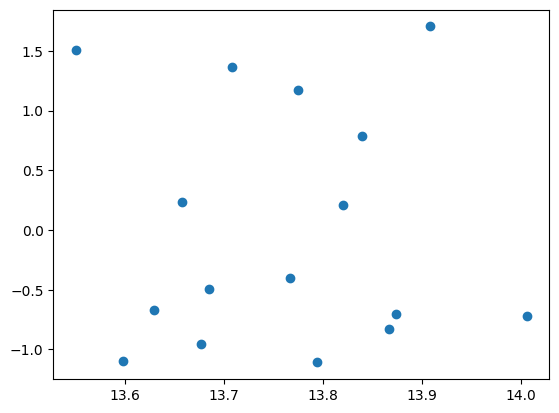

In [11]:
plt.scatter(ahi_pred.squeeze(1).tolist(), ahi_labels.squeeze(1).tolist())